Deep Learning has been being widely applied in medical domain applications. Medical image classification, localization and segementation tasks requires expert analysis by specialists. Due to the vastness of data and their complex patterns, it is incredibly hard to hand label them. Deep learning can be of a great assistance in these sort of tasks.

In this notebook, we will explore a specific medical dataset on detection of 4 types of abnormalities in chest X-ray images.  

## Dataset
I have collected and curated around 6k chest X-ray images with their respective abnormality types. The data is collected from the following sources:

- [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
- [COVID Chest X-ray Dataset](https://github.com/ieee8023/covid-chestxray-dataset)

### Loading all necessary libraries

In [3]:
import sys
import os
import random

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import KFold
from tqdm import tqdm_notebook as T
import platform

import torch
from torch.utils.data import Dataset
from torch import optim, nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.autograd import Variable
from torchvision import transforms

from PIL import Image, ImageFile
from torch.utils.data import Dataset


ImageFile.LOAD_TRUNCATED_IMAGES = True


In [6]:
data_dir = 'Chest_Xray_BSP'
train_df = pd.read_csv('Chest_Xray_BSP/train.csv')
test_df = pd.read_csv('Chest_Xray_BSP/test.csv')
train_dir = f'{data_dir}/train/'
test_dir = f'{data_dir}/test/'

### Adding a Fixed Seed Value

A fixed seed value always yields the same set of random numbers. 

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 24
seed_everything(SEED)

## Sample Images from Our Dataset

In [8]:
label_to_idx = {'Normal': 0, 'Viral_Pneumonia': 1, 'Bacterial_Pneumonia': 2, 'Covid': 3}
idx_to_label = {0: 'Normal', 1: 'Viral_Pneumonia', 2: 'Bacterial_Pneumonia', 3: 'Covid'}
train_df['label'] = train_df['Diagnosis'].map(label_to_idx)
test_df['label'] = test_df['Diagnosis'].map(label_to_idx)

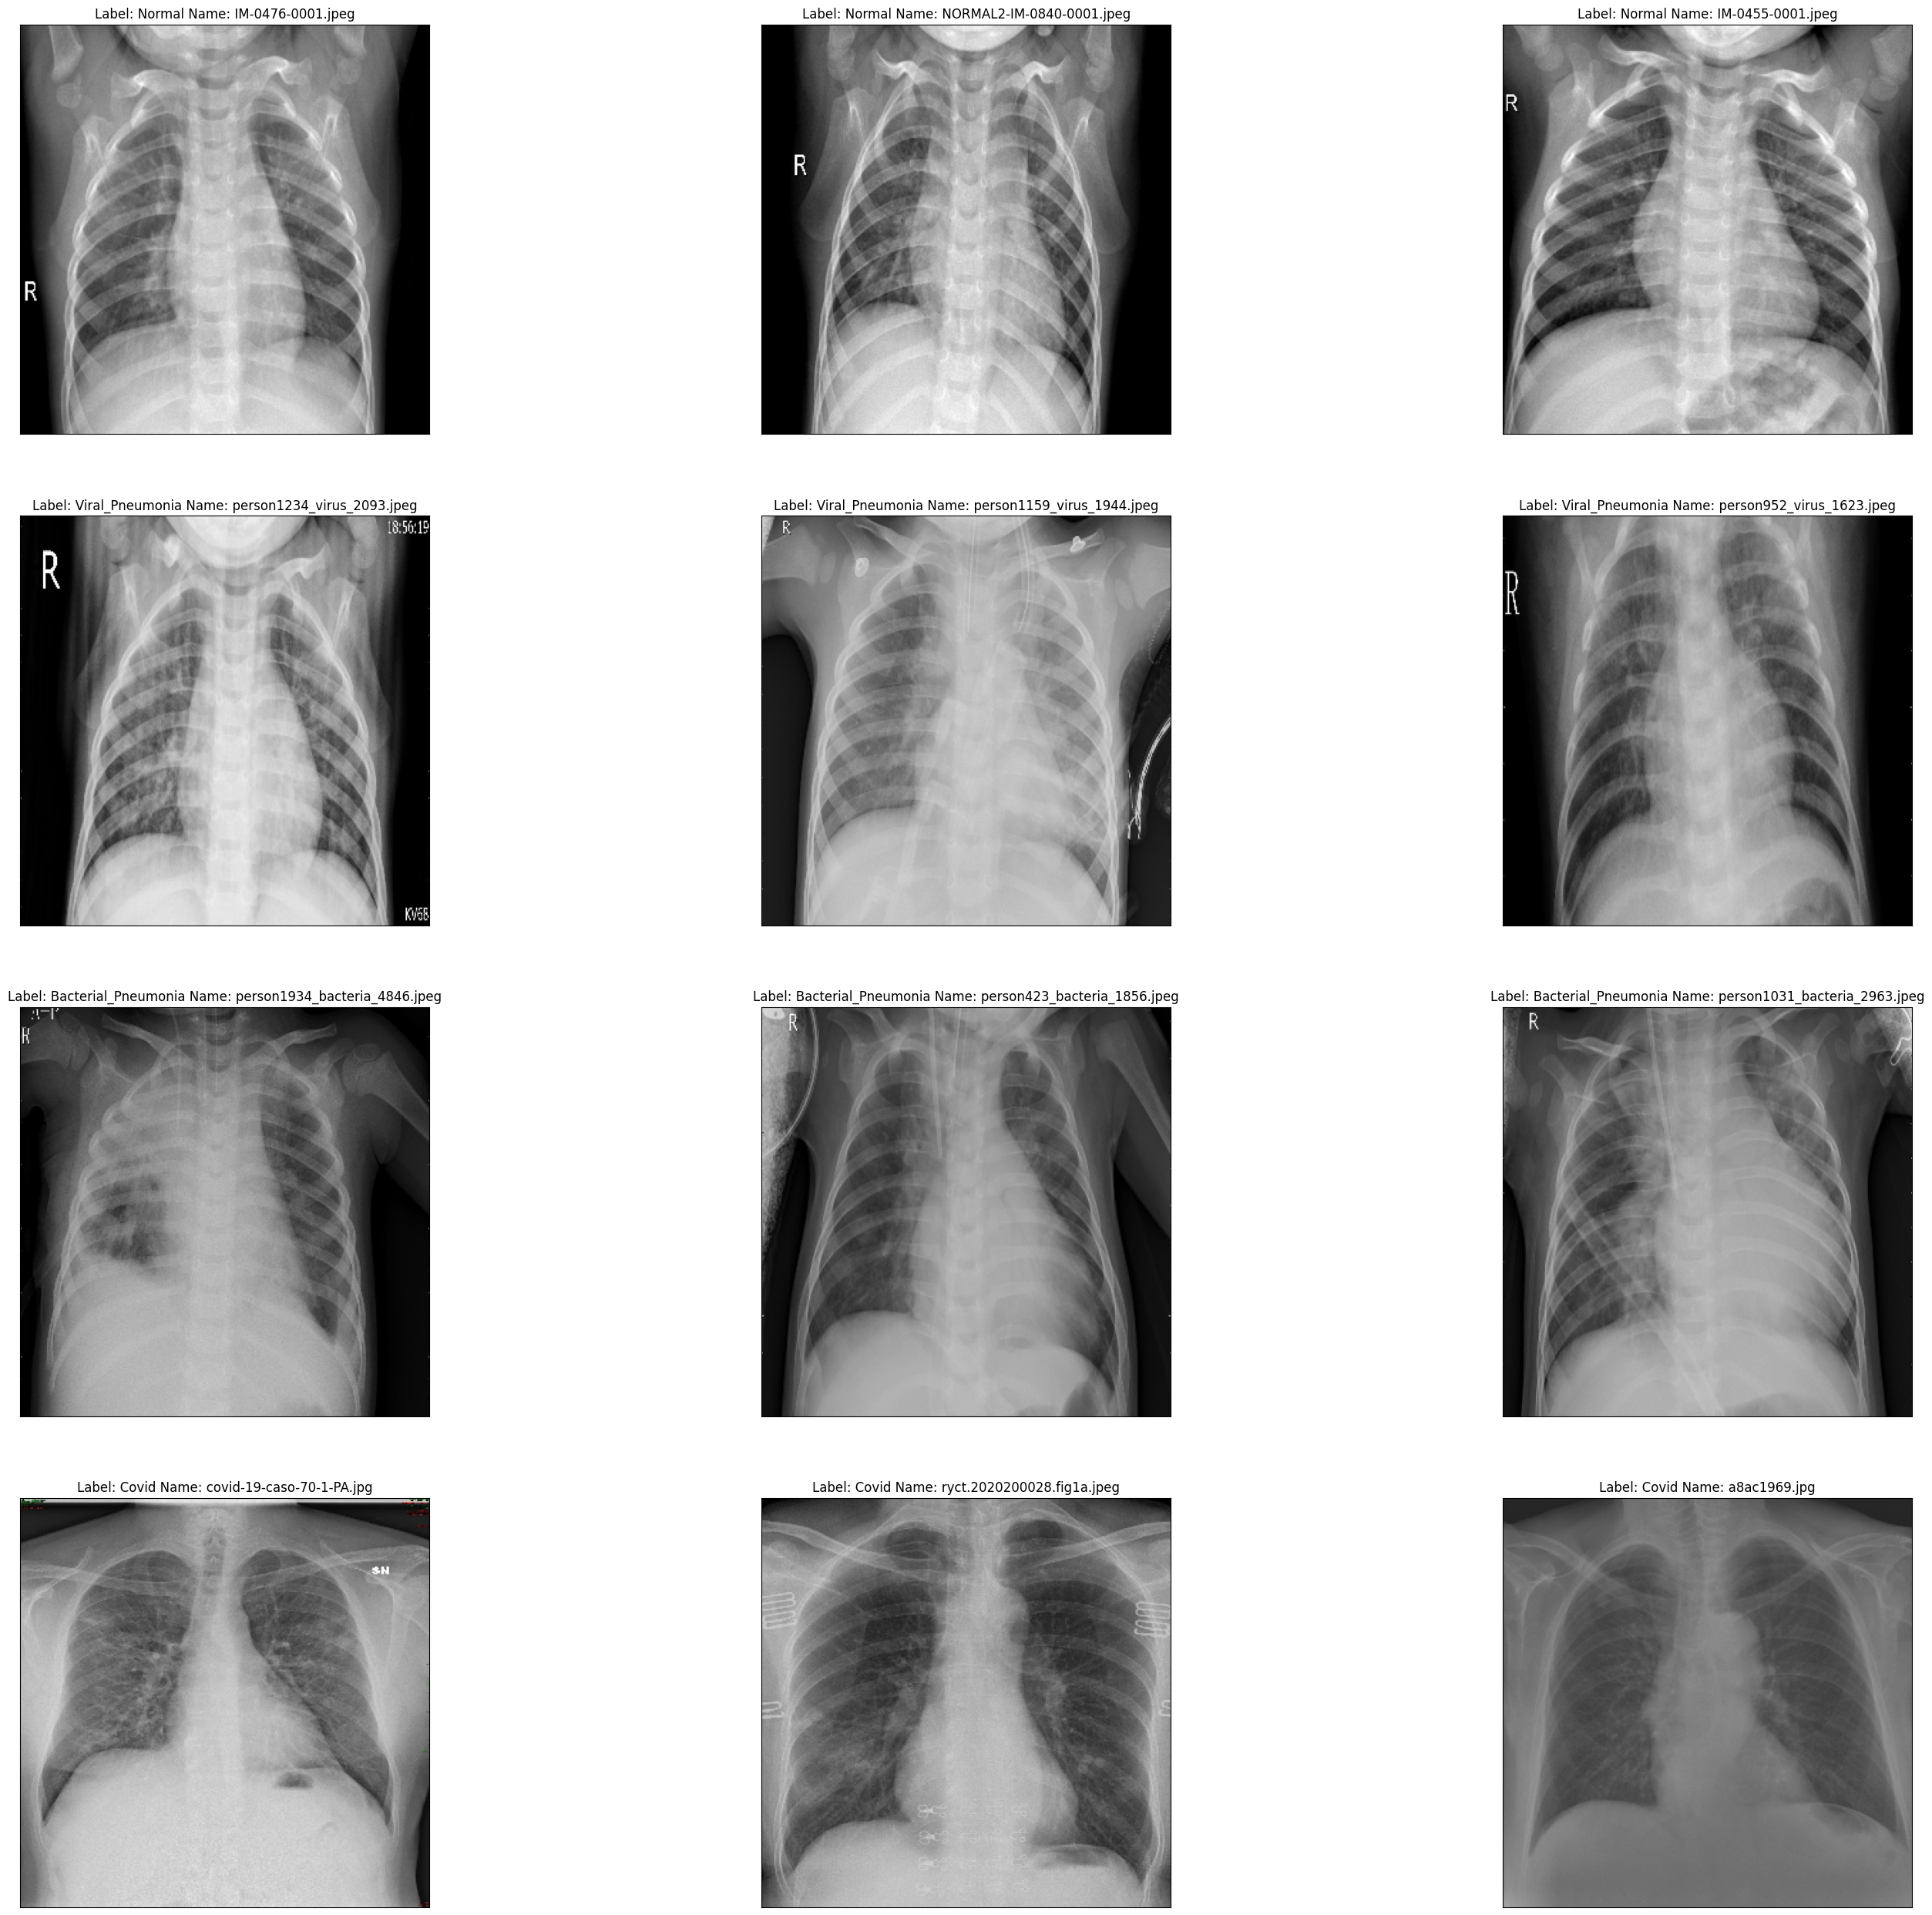

In [10]:
# Courtesy: https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy
from matplotlib import pyplot as plt
import os
import random

%matplotlib inline
fig = plt.figure(figsize=(60, 40))
for class_id in sorted(train_df['label'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['label'] == class_id].sample(3, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"{train_dir}/{row['image_name']}"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (320, 320))
        plt.imshow(image, cmap='bone')
        ax.set_title('Label: %s Name: %s' % (row['Diagnosis'], row['image_name']))

### Data Distribution

<Axes: >

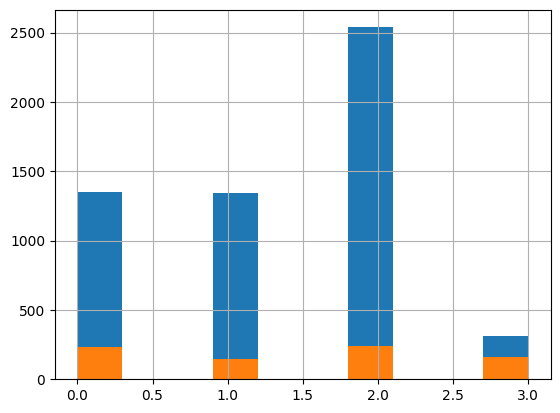

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
train_df.label.hist()
test_df.label.hist()

# Diving into Deep Learning

A deep learing model can be compared to a black box. In our case, input and output data are feeded to it's two ends and it learns to map input to output during training.

With all the resources we have by now, we can develop our pipeline for training a model. We will use **[Pytorch](https://pytorch.org/)** for the task. The procedures are described step by step below.

###  Convolutional Neural Networks 

Convolutional Neural Network is a special variant of Deep Neural Network. In Convolutional Neural Networks, every image input is treated as a a matrix of pixel values which represents the amount of darkness at a given pixel in the image. Unlike, tradational neural networks which treats an image as a one dimentional network, CNNs considers the location of pixels and the neighbours for classification.

<br>

![](http://www.mdpi.com/information/information-07-00061/article_deploy/html/images/information-07-00061-g001.png)

<br>

### Key components of Convolutional Neural Network. 

- **A. Convolutional layer: ** In this layer, a kernel (or weight) matrix is used to extract low level features from the images. The kernel with its weights rotates over the image matrix in a sliding window fashion in order to obtained the convolved output. The kernel matrix behaves like a filter in an image extracting particular information from the original image matrix. During the colvolution process, The weights are learnt such that the loss function is minimized.

- **B. Stride: ** Stride is defined as the number of steps the kernel or the weight matrix takes while moving across the entire image moving N pixel at a time. If the weight matrix moves N pixel at a time, it is called stride of N.

![](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif) 
Image Credits - www.deeplearning.net

- **C. Pooling Layer:**  Pooling layers are used to extract the most informative features from the generated convolved output. 

![](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

- **D. Output Layer:** To generate the final output, a dense or a fully connected layer is applied with the softmax activation function. Softmax function is used to generate the probabilities for each class of the target variable. 

**Courtesy: [A Very Comprehensive Tutorial : NN + CNN](https://www.kaggle.com/shivamb/a-very-comprehensive-tutorial-nn-cnn)**


## Possible Aproaches towards solving

This problem can be treated as a **Classification** problem. Here, output is a column vector of length dimension `4x1` for each input. If the level is *`n`*, then the *`n`*th row is `1` and the rest are `0` 

### Check Whether GPU is available or not

GPUs are optimized to do matrix operations much faster than CPUs. Since training models involve large matrix operations, using GPU facility would make these operations much faster and more precise. However, not all computers come with GPUs. So, we will check whether there is GPU available and if so, then we will load our data and model into it.

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")

## Setting Parameters for training

In [13]:
params = {'num_classes':4, 'criterion':nn.BCEWithLogitsLoss(), 'mixed_precision':False,
         'IMG_SIZE':256, 'num_epoch': 16, 'batch_size':32, 'learning_rate':2e-3, 'num_worker':4, 'n_fold':5}

### Train-Validation Split

Instead of training over the whole dataset, we often split it into two parts named train and validation sets and train over the train set only. We then monitor the model's performance over the validation set. A good validation set resembles test dataset i.e., their class distribution are same and the metrics obtained over them should be close. 

If the dataset is quiet large, it is safe to assume that it's class distribution will be similar to that of test/unknown data. We use `Stratified Split` to create a validation dataset with same class elements ratio. 

In [15]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
skf = StratifiedKFold(n_splits=params['n_fold'], shuffle=True, random_state=SEED)

X = train_df['image_name']
y = train_df['label']
train_idx = []
val_idx = []
for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    train_idx = train_index
    val_idx = val_index
    break
train = train_df.loc[train_idx]
valid = train_df.loc[val_idx]

### Dataset and Dataloader

There are several ways to load and feed data into a DNN. In Pytorch, we usually do it using `Dataset`. It is a class that samples chunks/batches of data from dataset. `Dataloader` is another class that uses `Dataset` to retrive data and/or corresponding outputs as batches. Later, these data batches are fed into model for training. In the following section, we will inherit pytorch's Dataset class and modify it in such a way that it will load images and corresponding abnormality levels and return them after applying some preprocessing. 

In [16]:
class CXRDataset(Dataset):
    def __init__(self, dirname, df, dim, transformer):
        super(Dataset, self).__init__()
        self.data = df
        self.dim = dim
        self.dirname = dirname
        self.transformer = transformer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        img_name = os.path.join(self.dirname, self.data.loc[item, 'image_name'])
        image = cv2.imread(img_name)
        image = cv2.resize(image, (self.dim, self.dim))
        image = Image.fromarray(image)
        raw_label = [self.data.loc[item, 'label']]
        
        label = np.zeros((len(raw_label), params['num_classes']))
        label[np.arange(len(raw_label)),raw_label] = 1
        label = torch.LongTensor(label)
                        
        return self.transformer(image), label


## Augmentations
Augmentations are used to increase diversity of data available for training models, without actually collecting new data. It helps the model to genearalize and prevents overfitting.

In [17]:
# Data Augmentations
train_transform = transforms.Compose([
    transforms.RandomRotation(360),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])


### Training with a Pretrained Model

Training a model from scratch often requires a long time to converge and it does not generalize well. To avoid this problem, it is a common practice to use a model that was trained over a large dataset before and is well-generalized. One major advantage of using a pretrained model is that their top layers are capable of extracting general features irrespective of any image domain. We initiate training from the weights of that pretrained model. Sometimes, we freeze selective top layers to avoid overfitting and force it to generalize well.

In [18]:
class CXRPretrainedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(2048, 256)
        self.out = nn.Linear(256, params['num_classes'])
    
    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)
        x = self.out(x)
        return x


### Creating model object, loss fucntion and optimizers

In [19]:
pretrained_model = CXRPretrainedModel().to(device)
criterion = params['criterion']
lr = params['learning_rate']
plist = [
    {'params': pretrained_model.model.parameters(), 'lr':lr/100},
    {'params': pretrained_model.out.parameters(), 'lr':lr}
]
optimizer = optim.Adam(plist, lr=lr)
lr_reduce_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, threshold=1e-4, threshold_mode='rel', cooldown=0, min_lr=1e-7, eps=1e-08)

c:\Users\Admin\Desktop\pneumonia\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\Desktop\pneumonia\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.4MB/s]
c:\Users\Admin\Desktop\pneumonia\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please us

## Mixed Precision

Mixed precision is the combined use of different numerical precisions in a computational method.

Half precision (also known as FP16) data compared to higher precision FP32 vs FP64 reduces memory usage of the neural network, allowing training and deployment of larger networks, and FP16 data transfers take less time than FP32 or FP64 transfers.

Single precision (also known as 32-bit) is a common floating point format (float in C-derived programming languages), and 64-bit, known as double precision (double).

Deep Neural Networks (DNNs) have led to breakthroughs in a number of areas, including image processing and understanding, language modeling, language translation, speech processing, game playing, and many others. DNN complexity has been increasing to achieve these results, which in turn has increased the computational resources required to train these networks.

Source: [NVIDIA Accelerated Computing](https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html)

In [20]:
mixed_precision = params['mixed_precision']
if mixed_precision:
    ! git clone https://github.com/NVIDIA/apex
    os.chdir('apex')
    ! pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
    os.chdir('../')
    from apex import amp
    amp.initialize(basic_model, optimizer, opt_level='O1')

### Metric
We are going to use [F Score](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/) for our model evaluation.

### Funtions for Training and Evaluation

In [21]:
def save_model(valid_loss, valid_f1, best_valid_loss, best_valid_f1, best_state, savepath):
    if valid_loss<best_valid_loss:
        print(f'Validation loss has decreased from:  {best_valid_loss:.4f} to: {valid_loss:.4f}. Saving checkpoint')
        torch.save(best_state, savepath+'_loss.pth')
        best_valid_loss = valid_loss
    if valid_f1>best_valid_f1:
        print(f'Validation F1 score has increased from:  {best_valid_f1:.4f} to: {valid_f1:.4f}. Saving checkpoint')
        torch.save(best_state, savepath + '_f1.pth')
        best_valid_f1 = valid_f1
    else:
        torch.save(best_state, savepath + '_last.pth')
    return best_valid_loss, best_valid_f1 

In [22]:
from sklearn.metrics import f1_score

def train_val(epoch, dataloader, model, optimizer, train=True, mode='train'):
    t1 = time.time()
    running_loss = 0
    epoch_samples = 0
    pred = []
    lab = []
    if train:
        model.train()
        print("Initiating train phase ...")
    else:
        model.eval()
        print("Initiating val phase ...")
    for idx, (img,labels) in enumerate(dataloader):
        epoch_samples += img.size(0)
        with torch.set_grad_enabled(train):
            img = img.to(device, dtype=torch.float)
            labels = torch.squeeze(labels).to(device, dtype=torch.float)
            outputs = model(img)
            loss = criterion(outputs, labels)
            running_loss += loss.sum().item()
            if train:
                if mixed_precision:
                    with amp.scale_loss(loss, optimizer) as scaled_loss:
                        scaled_loss.backward()
                else:
                    loss.backward()

                    optimizer.step()
                    optimizer.zero_grad()

        elapsed = int(time.time() - t1)
        eta = int(elapsed / (idx+1) * (len(dataloader)-(idx+1)))
        pred.extend(torch.argmax(outputs, dim=1).detach().cpu().numpy())
        lab.extend(torch.argmax(labels, dim=1).cpu().numpy())
        
        if train:
            msg = f"Epoch: {epoch} Progress: [{idx}/{len(dataloader)}] loss: {(running_loss/epoch_samples):.4f} Time: {elapsed}s ETA: {eta} s"
        else:
            msg = f'Epoch {epoch} Progress: [{idx}/{len(dataloader)}] loss: {(running_loss/epoch_samples):.4f} Time: {elapsed}s ETA: {eta} s'
        print(msg, end= '\r')
    history.loc[epoch, f'{mode}_loss'] = running_loss/epoch_samples
    history.loc[epoch, f'{mode}_time'] = elapsed
    if mode=='val':
        f1 = f1_score(lab, pred, average='weighted')
        lr_reduce_scheduler.step(running_loss)
        msg = f'{mode} Loss: {running_loss/epoch_samples:.4f} \n {mode} F1 Score: {f1:.4f}'
        print(msg)
        history.loc[epoch, f'{mode}_loss'] = running_loss/epoch_samples
        history.loc[epoch, f'{mode}_f1_score'] = f1
        history.to_csv(f'history.csv', index=False)
        return lab, pred, running_loss/epoch_samples, f1
    elif mode == 'test':
        f1 = f1_score(lab, pred, average='weighted')
        return lab, pred, running_loss/epoch_samples, f1
    else:
        return model

In [23]:
train_dataset = CXRDataset(train_dir, train.reset_index(drop=True), params['IMG_SIZE'], train_transform)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=4)
val_dataset = CXRDataset(train_dir, valid.reset_index(drop=True), params['IMG_SIZE'], val_transform)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size']//2, shuffle=True,num_workers= params['num_worker'])
test_dataset = CXRDataset(test_dir, test_df.reset_index(drop=True), params['IMG_SIZE'], val_transform)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size']//2, shuffle=True,num_workers= params['num_worker'])

In [24]:
import gc
import time

def main(model):
    prev_epoch_num = 0
    best_valid_loss = np.inf
    best_valid_f1 = 0.0
  
    for epoch in range(params['num_epoch']):
        torch.cuda.empty_cache()
        print(gc.collect())

        model = train_val(epoch, train_data_loader, model=model, optimizer=optimizer, train=True, mode='train')
        _, _, valid_loss, valid_f1 = train_val(epoch, val_data_loader, model=model, optimizer=optimizer, train=False, mode='val')
        print("#"*20)
        print(f"Epoch {epoch} Report:")
        print(f"Validation Loss: {valid_loss :.4f} Validation F1 Score: {valid_f1 :.4f}")
        best_state = {'model': model.state_dict(), 'optim': optimizer.state_dict(), 'scheduler':lr_reduce_scheduler.state_dict(), 
        
        # 'cyclic_scheduler':cyclic_scheduler.state_dict(), 
#             'scaler': scaler.state_dict(),
        'best_loss':valid_loss, 'best_f1':valid_f1, 'epoch':epoch}
        best_valid_loss, best_valid_f1 = save_model(valid_loss, valid_f1, best_valid_loss, best_valid_f1, best_state, './CXR_model')
        print("#"*20)

In [25]:
if mixed_precision:
    amp.initialize(pretrained_model, optimizer, opt_level='O1')

In [ ]:
history = pd.DataFrame()
main(pretrained_model)

2753
Initiating train phase ...


### Prediction

Now we will load our best model and predict labels for test data using it.

In [1]:
tmp = torch.load('./CXR_model_f1.pth')
print('Model loaded')
# loadinig weights
pretrained_model.load_state_dict(tmp['model'])
predictions, actual_labels, test_loss, test_f1 = train_val(-1, test_data_loader, model=pretrained_model, optimizer=optimizer, train=False, mode='test')
print(f'Test Loss: {test_loss} Test F1: {test_f1}')

NameError: name 'torch' is not defined

In [2]:
predictions = [idx_to_label[p] for p in predictions]
actual_labels = [idx_to_label[p] for p in actual_labels]

NameError: name 'predictions' is not defined

In [3]:
from IPython.display import FileLink

# Create a download link
FileLink(r'./CXR_model_f1.pth')


c:\Users\Admin\Desktop\pneumonia\CXR_model_f1.pth

# Prediction Visualization

## Loss

In [4]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, edgecolor='k')
history = pd.read_csv('./history.csv')
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

NameError: name 'pd' is not defined

<Figure size 640x480 with 0 Axes>

## F1 Score 

In [5]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='1', edgecolor='k')
plt.plot(history['val_f1_score'], label='validation f1 score')

plt.title('Training history')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend()

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

## Confusion Matrix

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = list(idx_to_label.values())
cm = confusion_matrix(predictions, actual_labels, labels)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

ModuleNotFoundError: No module named 'seaborn'

## GradCAM

In [ ]:
pip uninstall setuptools_scm


In [ ]:
! pip install setuptools_scm==6.0.1



In [7]:
! pip install -q pytorch-gradcam

In [8]:
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam

def grad_cam_gen(model, img, mixed_precision = False, device = 'cuda'):
    if mixed_precision:
        model, optim = amp.initialize(model, optim, opt_level='O1')
         
    configs = [dict(model_type='resnet', arch=model, layer_name='layer4')]
    for config in configs:
        config['arch'].to(device).eval()

    cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
        for config in configs]

    for _, gradcam_pp in cams:
        mask_pp, _ = gradcam_pp(img)
        heatmap_pp, result_pp = visualize_cam(mask_pp, img)
        result_pp = result_pp.cpu().numpy()
        #convert image back to Height,Width,Channels
        result_pp = np.transpose(result_pp, (1,2,0))
        return result_pp


In [ ]:
from torchvision import models

%matplotlib inline
fig = plt.figure(figsize=(70, 56))
for class_id in sorted(test_df['label'].unique()):
    for i, (idx, row) in enumerate(test_df.loc[test_df['label'] == class_id].sample(3, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"{test_dir}/{row['image_name']}"
        image = cv2.imread(path)
        image = cv2.resize(image, (256, 256))
        image = Image.fromarray(image)
        image = val_transform(image)
        prediction = torch.argmax(pretrained_model(torch.unsqueeze(image.to(device), dim=0)))
        prediction = prediction.data.cpu().numpy()
        pred_label = idx_to_label[int(prediction)]
        image = grad_cam_gen(pretrained_model.model, torch.unsqueeze(image, dim=0).cuda())
        plt.imshow(image, cmap='bone')
        ax.set_title('Label: %s Prediction: %s' % (row['Diagnosis'], pred_label))

## Next Tasks

- Add ConvXNet model
- Multilabel Classification
- Add `learning rate scheduler`, `layer wise different learning rate` etc magic features for better optimization.